In [1]:
cd

/Users/dmytro


In [2]:
cd Documents/Projects/PROJECT_main/bsc-thesis-vdu/libs

/Users/dmytro/Documents/Projects/PROJECT_main/bsc-thesis-vdu/libs


In [3]:
ls

__pycache__/     read_pd_data.py


In [4]:
from read_pd_data import readMatData
import matplotlib.pyplot as plt
import mne
import numpy as np
from mne.datasets import sample
import pandas as pd
from mne_features.univariate import compute_spect_slope
from mne_features.utils import power_spectrum
from os import walk
from scipy.io import loadmat
from scipy import signal

import re

print(__doc__)

Automatically created module for IPython interactive environment


In [5]:
cd

/Users/dmytro


In [6]:
cd Documents/Projects/PROJECT_main/bsc-thesis-vdu/

/Users/dmytro/Documents/Projects/PROJECT_main/bsc-thesis-vdu


### 1.1 Testing Extract Slope Features

In [7]:
sign, t, y = readMatData('ctrl', 1)

data = y[35,].reshape(1, -1)
sfreq = 512.0

psd, freqs = power_spectrum(sfreq, data)
print(psd.shape)
mask = np.logical_and(0 <= freqs, freqs <= 50)
psd, freqs = psd[0, mask], freqs[mask]

intercept, slope, _, _ = compute_spect_slope(sfreq, data, fmin=38., fmax=42.)
print('The estimated slope is a = %1.2f and the estimated intercept is '
      'b = %1.3e' % (slope, intercept))

Reading files started..
(1, 129)
The estimated slope is a = -3.66 and the estimated intercept is b = 7.801e-01


In [8]:
t.shape, y.shape, sign.shape

((79824,), (116, 79824), (79824, 116))

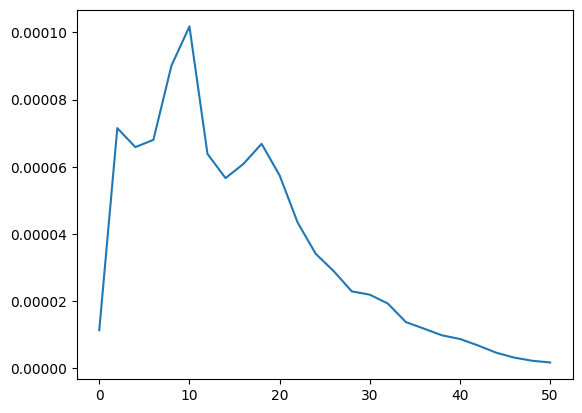

In [9]:
plt.plot(freqs, psd);

In [10]:
pwd

'/Users/dmytro/Documents/Projects/PROJECT_main/bsc-thesis-vdu'

### 1.2 Create slope features for each subject

In [11]:
#  Function for creating Slope features for each patient   #
#  5 freq. bands --> 5 * 116 channels --> 580 features     #
# _______________________________________________________ #

def createFeatures(subjectType, subjectNum, ctrl_list, pd_list):
    if subjectType == 'pd':
        matlabfile = "data/PD_broad/" + pd_list[subjectNum] 
    elif subjectType == 'ctrl':
        matlabfile = "data/_CTRL_PD_broad/" + ctrl_list[subjectNum]

    loadedfile = loadmat(matlabfile)
    
    dat = loadedfile['dati_bf']
    t = dat['time'].flatten()[0].flatten()
    y = dat['trial_norm'].flatten()[0].flatten() # [0]
    
    all_timepoints = [t[i] for i in range(len(t))]
    final_t = np.hstack(all_timepoints).reshape(-1)
    all_signals = [y[i] for i in range(len(y))]
    final_y = np.hstack(all_signals)
        
    sign = pd.DataFrame(data=final_y.T, index=final_t)
    print('Signal is of shape:', sign.shape)
    
    fs = 512.0
    slopes = dict()

    for i in range(0, 116):
        data = sign.iloc[:, i].values.reshape(1, -1)
        # define 5 freq bands of interest
        slope_bands = {'Delta': (0.5, 4),
                     'Theta': (4, 8),
                     'Alpha': (8, 12),
                     'Beta': (12, 30),
                     'Gamma': (30, 100)}

        for band in slope_bands:  
            f_min, f_max = slope_bands[band][0], slope_bands[band][1]
            _, slope, _, _ = compute_spect_slope(fs, data, fmin=f_min, fmax=f_max)
            slopes['Slope_{}_channel{}'.format(band, i+1)] = slope

    
    return pd.DataFrame(slopes.values(), slopes.keys()).T

In [12]:
def list_of_path_files(dir_path):
    res = []
    for (dir_path, dir_names, file_names) in walk(dir_path):
        res.extend(file_names)
        # don't look inside any subdirectory
        break
    #print(res)
    return res

# extract names of files
pd_list = list_of_path_files('data/PD_broad')
ctrl_list = list_of_path_files('data/_CTRL_PD_broad')

In [13]:
pd_list[:2]

['BRNNNA56_01_512_broad.mat', 'CFRGNN51_01_512_broad.mat']

In [14]:
# Fill lists with features for each CTRL/PD patient

subj_ctrl_data = []  # Create an empty list to store the results

for i in range(20):
    subj_ctrl_data.append(createFeatures('ctrl', i, ctrl_list, pd_list))
    
subj_pd_data = []  # Create an empty list to store the results

for i in range(20):
    subj_pd_data.append(createFeatures('pd', i, ctrl_list, pd_list))

Signal is of shape: (78245, 116)
Signal is of shape: (79824, 116)
Signal is of shape: (72654, 116)
Signal is of shape: (69703, 116)
Signal is of shape: (72430, 116)
Signal is of shape: (82072, 116)
Signal is of shape: (66002, 116)
Signal is of shape: (73091, 116)
Signal is of shape: (52921, 116)
Signal is of shape: (65184, 116)
Signal is of shape: (80445, 116)
Signal is of shape: (56439, 116)
Signal is of shape: (75834, 116)
Signal is of shape: (70552, 116)
Signal is of shape: (79492, 116)
Signal is of shape: (73759, 116)
Signal is of shape: (55799, 116)
Signal is of shape: (77079, 116)
Signal is of shape: (76858, 116)
Signal is of shape: (53559, 116)
Signal is of shape: (73369, 116)
Signal is of shape: (81971, 116)
Signal is of shape: (76655, 116)
Signal is of shape: (71038, 116)
Signal is of shape: (73569, 116)
Signal is of shape: (44738, 116)
Signal is of shape: (76281, 116)
Signal is of shape: (79676, 116)
Signal is of shape: (77897, 116)
Signal is of shape: (67103, 116)
Signal is 

### 1.3 Merge all data into one dataframe and save it

In [15]:
final_pd_df = pd.concat(subj_pd_data, axis=0) 
final_pd_df['target'] = 1

final_ctrl_df = pd.concat(subj_ctrl_data, axis=0) 
final_ctrl_df['target'] = 0

final_df = pd.concat([final_ctrl_df, final_pd_df], axis=0)
final_df.head()

,Slope_Delta_channel1,Slope_Theta_channel1,Slope_Alpha_channel1,Slope_Beta_channel1,Slope_Gamma_channel1,Slope_Delta_channel2,Slope_Theta_channel2,Slope_Alpha_channel2,Slope_Beta_channel2,Slope_Gamma_channel2,...,Slope_Theta_channel115,Slope_Alpha_channel115,Slope_Beta_channel115,Slope_Gamma_channel115,Slope_Delta_channel116,Slope_Theta_channel116,Slope_Alpha_channel116,Slope_Beta_channel116,Slope_Gamma_channel116,target
0,-0.306048,-0.076067,-1.972159,-1.396093,-9.893321,-0.208654,0.145119,-2.074306,-1.644612,-9.740320,...,1.421544,-2.031883,-1.782430,-9.952042,-0.137946,1.462743,-2.055009,-1.787130,-10.003358,0
0,-0.723168,0.468160,-1.104337,-1.360878,-9.889068,-0.555383,0.221350,-0.707420,-1.334701,-10.188527,...,1.237098,-0.321056,-1.573043,-10.225805,-0.039740,1.397402,-0.415047,-1.639541,-10.125254,0
0,-0.657620,0.282428,-1.511900,-0.661253,-9.859703,-0.891532,0.576166,-1.867962,-1.253581,-9.645000,...,1.343854,-2.030068,-1.847695,-9.141395,-0.493025,1.288020,-1.950359,-1.797956,-9.183274,0
0,-0.851572,-1.360808,0.023854,-0.572560,-9.880788,-0.919218,-1.122783,0.605264,-0.981192,-9.455431,...,-0.461632,0.985291,-1.803151,-9.038920,-0.745013,-0.564793,1.002989,-1.633470,-9.003338,0
0,-0.727072,0.564501,-0.949918,-1.210446,-9.980929,-0.693245,0.662302,-1.103339,-1.814917,-9.796032,...,1.944810,-1.359927,-2.414122,-9.124230,-0.505233,1.869712,-1.389887,-2.314490,-9.187275,0


In [16]:
df_slopes = final_df.reset_index(drop=True) 

In [17]:
df_slopes.head()

,Slope_Delta_channel1,Slope_Theta_channel1,Slope_Alpha_channel1,Slope_Beta_channel1,Slope_Gamma_channel1,Slope_Delta_channel2,Slope_Theta_channel2,Slope_Alpha_channel2,Slope_Beta_channel2,Slope_Gamma_channel2,...,Slope_Theta_channel115,Slope_Alpha_channel115,Slope_Beta_channel115,Slope_Gamma_channel115,Slope_Delta_channel116,Slope_Theta_channel116,Slope_Alpha_channel116,Slope_Beta_channel116,Slope_Gamma_channel116,target
0,-0.306048,-0.076067,-1.972159,-1.396093,-9.893321,-0.208654,0.145119,-2.074306,-1.644612,-9.740320,...,1.421544,-2.031883,-1.782430,-9.952042,-0.137946,1.462743,-2.055009,-1.787130,-10.003358,0
1,-0.723168,0.468160,-1.104337,-1.360878,-9.889068,-0.555383,0.221350,-0.707420,-1.334701,-10.188527,...,1.237098,-0.321056,-1.573043,-10.225805,-0.039740,1.397402,-0.415047,-1.639541,-10.125254,0
2,-0.657620,0.282428,-1.511900,-0.661253,-9.859703,-0.891532,0.576166,-1.867962,-1.253581,-9.645000,...,1.343854,-2.030068,-1.847695,-9.141395,-0.493025,1.288020,-1.950359,-1.797956,-9.183274,0
3,-0.851572,-1.360808,0.023854,-0.572560,-9.880788,-0.919218,-1.122783,0.605264,-0.981192,-9.455431,...,-0.461632,0.985291,-1.803151,-9.038920,-0.745013,-0.564793,1.002989,-1.633470,-9.003338,0
4,-0.727072,0.564501,-0.949918,-1.210446,-9.980929,-0.693245,0.662302,-1.103339,-1.814917,-9.796032,...,1.944810,-1.359927,-2.414122,-9.124230,-0.505233,1.869712,-1.389887,-2.314490,-9.187275,0


In [18]:
df_slopes.shape

(40, 581)

In [19]:
df_slopes.to_csv('data/slopes_580features.csv', index=False)

### 3.1 Testing Extract Power Spectrum features

In [20]:
def makePsdPlot(sign):
    plt.figure(figsize=(15, 3))
    
    fs = 512.0
    win = 10 * fs
    
    for i in range(0, 2):
        plt.subplot(1, 2, i+1)
        
        data = sign.iloc[:, i]
        freqs, psd = signal.welch(data, fs=512.0, nperseg=win)
        
        intervals = [0.5, 4, 8, 12, 30, 100]

        # Add vertical lines for each interval
        for interval in intervals:
            plt.axvline(x=interval, color='r', linestyle='--', label=f'Interval {interval}')
        plt.plot(freqs, psd)
        plt.xlim([0, 48])
        plt.xlabel('Frequency (Hz)')
        if i == 0:
            plt.ylabel('Power Spectral Density (dB/Hz)')
        plt.title(f'Channel {i+1}')
    
    plt.show()

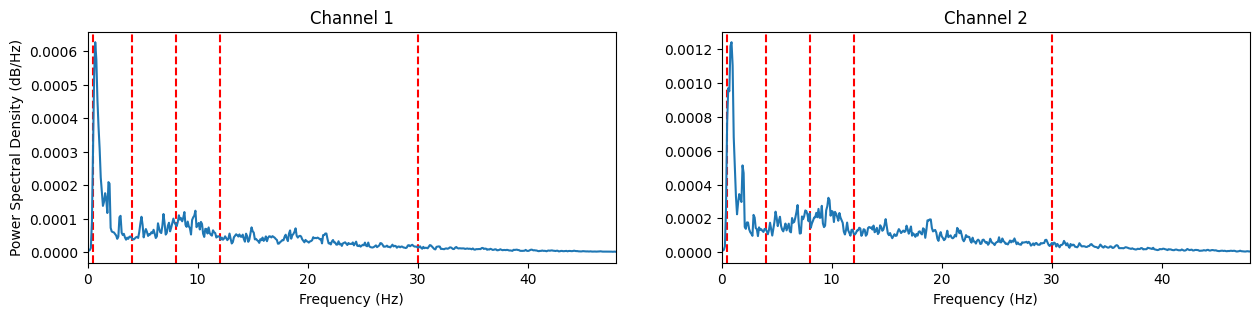

In [21]:
makePsdPlot(sign)

In [31]:
def createFeaturesPSD(subjectType, subjectNum, ctrl_list, pd_list):
    pattern = r"^(.*?_512)"
    
    if subjectType == 'pd':
        matlabfile = "data/PD_broad/" + pd_list[subjectNum] 
        PATIENT_ID = re.match(pattern, pd_list[subjectNum]).group(1)
    elif subjectType == 'ctrl':
        matlabfile = "data/_CTRL_PD_broad/" + ctrl_list[subjectNum]
        PATIENT_ID = re.match(pattern, pd_list[subjectNum]).group(1)

    loadedfile = loadmat(matlabfile)
    
    dat = loadedfile['dati_bf']
    t = dat['time'].flatten()[0].flatten()
    y = dat['trial_norm'].flatten()[0].flatten() # [0]
    
    #print('Timepoints are divided into #timepoints:', len(t))
    all_timepoints = [t[i] for i in range(len(t))]
    final_t = np.hstack(all_timepoints).reshape(-1)
    
    #print('Signal is divided into #signals:', len(y))
    all_signals = [y[i] for i in range(len(y))]
    final_y = np.hstack(all_signals)
    print(final_y[0, 0])
        
    sign = pd.DataFrame(data=final_y.T, index=final_t)
    print('Signal is of shape:', sign.shape)
    
    fs = 512.0
    win = 10 * fs

    meg_power_fft = dict()

    for i in range(0, 116):
        data = sign.iloc[:, i]

        freqs, psd = signal.welch(data, fs, nperseg=win)

        fft_vals = np.absolute(np.fft.rfft(data))

        power_vals = np.square(fft_vals)

        fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)

        meg_bands = {'Delta': (0.5, 4),
                     'Theta': (4, 8),
                     'Alpha': (8, 12),
                     'Beta': (12, 30),
                     'Gamma': (30, 48)}

        meg_band_fft = dict()

        for band in meg_bands:  
            freq_ix = np.where((fft_freq >= meg_bands[band][0]) & 
                               (fft_freq <= meg_bands[band][1]))[0]
            meg_band_fft[band] = np.mean(fft_vals[freq_ix])

        #meg_power_fft = dict()
        for band in meg_bands:  
            freq_ix = np.where((fft_freq >= meg_bands[band][0]) & 
                               (fft_freq <= meg_bands[band][1]))[0]
            meg_power_fft['{}_channel{}'.format(band, i)] = np.mean(power_vals[freq_ix])
            
    final_df = pd.DataFrame(meg_power_fft.values(), meg_power_fft.keys()).T
    #final_df['PATIENT_ID'] = PATIENT_ID
    return final_df

In [32]:
subj_pd_data = []  # Create an empty list to store the results

for i in range(20):
    subj_pd_data.append(createFeaturesPSD('pd', i, ctrl_list, pd_list))
    
subj_ctrl_data = []  # Create an empty list to store the results

for i in range(20):
    subj_ctrl_data.append(createFeaturesPSD('ctrl', i, ctrl_list, pd_list))

0.011199491727325015
Signal is of shape: (73369, 116)
-0.001640187528092151
Signal is of shape: (81971, 116)
0.012238277403858014
Signal is of shape: (76655, 116)
-0.014694018859542112
Signal is of shape: (71038, 116)
-0.014745808514186866
Signal is of shape: (73569, 116)
0.03532331462811481
Signal is of shape: (44738, 116)
0.01846803646548737
Signal is of shape: (76281, 116)
-0.012812252963512738
Signal is of shape: (79676, 116)
-0.03983137940189215
Signal is of shape: (77897, 116)
0.01191850653327774
Signal is of shape: (67103, 116)
0.04012456768818531
Signal is of shape: (84890, 116)
-0.07317745666628656
Signal is of shape: (73049, 116)
0.019357586748737343
Signal is of shape: (98695, 116)
-0.03827891817914811
Signal is of shape: (71586, 116)
0.008774728907377634
Signal is of shape: (65728, 116)
0.05687355653648385
Signal is of shape: (42208, 116)
-0.007985591600891514
Signal is of shape: (78561, 116)
-0.003635753972889059
Signal is of shape: (85033, 116)
0.00216536606318424
Signal 

In [33]:
final_pd_df = pd.concat(subj_pd_data, axis=0) 
final_pd_df['target'] = 1

final_ctrl_df = pd.concat(subj_ctrl_data, axis=0) 
final_ctrl_df['target'] = 0

In [34]:
final_df = pd.concat([final_ctrl_df, final_pd_df], axis=0)

In [35]:
df_psd = final_df.reset_index(drop=True)

In [36]:
df_psd.head()

,Delta_channel0,Theta_channel0,Alpha_channel0,Beta_channel0,Gamma_channel0,Delta_channel1,Theta_channel1,Alpha_channel1,Beta_channel1,Gamma_channel1,...,Theta_channel114,Alpha_channel114,Beta_channel114,Gamma_channel114,Delta_channel115,Theta_channel115,Alpha_channel115,Beta_channel115,Gamma_channel115,target
0,2308.444218,1219.314049,1121.515325,295.488834,89.144014,5965.272868,3669.501888,3878.959773,799.101306,205.805622,...,6815.570720,16793.335564,2035.576482,554.060527,10857.900604,9184.513353,21926.834967,2709.076813,759.113061,0
1,3281.766691,1324.146124,1562.018367,674.516976,143.460523,7450.526292,3508.011259,3967.721773,1927.957952,455.949151,...,2424.635150,5500.244278,1569.035776,328.817517,4241.164950,4209.476195,9455.433146,2504.692819,469.660520,0
2,747.312306,329.477873,362.135408,151.838476,51.112399,2547.192424,990.952011,1387.504255,388.921652,106.367130,...,4993.411658,10874.042851,1712.853163,337.353042,12246.772461,6494.796435,14084.482299,2355.349862,470.040654,0
3,2600.860612,493.980395,377.710136,302.683334,120.903401,7781.252126,1465.669735,1589.779544,1011.487181,279.222818,...,2089.456492,4281.541837,2344.405562,429.596002,11614.140005,3105.537695,6107.518592,3376.275217,658.990113,0
4,3265.113160,1114.710590,1554.991710,640.952684,172.871722,6716.523260,2715.544713,4316.685914,1237.838429,272.013394,...,3917.473470,14687.861447,2490.165218,207.475599,7527.934876,4661.270321,17211.050355,2966.345924,272.300652,0


In [37]:
df_psd.shape

(40, 581)

In [38]:
df_psd['target'].value_counts()

0    20
1    20
Name: target, dtype: int64

In [39]:
df_psd.to_csv('data/psd_580features.csv', index=False)